# Multilayer Perceptron Supervised Anomaly Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import seaborn as sns
print('seaborn: ', sns.__version__)

seaborn:  0.13.2


In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
"dst_bytes", "land", "wrong_fragment", "urgent", 
"hot", "num_failed_logins", "logged_in", "num_compromised", 
"root_shell", "su_attempted", "num_root", 
"num_file_creations", "num_shells", "num_access_files", 
"num_outbound_cmds", "is_host_login", 
"is_guest_login", "count", "srv_count", "serror_rate",
"srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
"same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", 
"dst_host_count", "dst_host_srv_count", 
"dst_host_same_srv_rate", "dst_host_diff_srv_rate",
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
"dst_host_serror_rate", "dst_host_srv_serror_rate",
"dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("./kddcup.data/kddcup.data.corrected", sep=",", names=columns, index_col=None) 

Filter to only 'http' attacks

In [3]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)

In [4]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))

encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder

Check the variables with highest correlation with 'label'

In [6]:
df2 = df.copy()
label_corr = df2.corr()['label']

Filter out anything that has null entry or is not weakly correlated

In [7]:
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
train_cols

['src_bytes',
 'hot',
 'num_compromised',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [8]:
labels = df2['label']

Conduct a train-test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size=0.15, random_state=42)

Additional split of training dataset to create validation split

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [11]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


# Simple Neural Network: Keras

In [12]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [13]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701, 2)

x_val:(105926, 13)
y_val:(105926, 2)

x_test:(93464, 13)
y_test:(93464, 2)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

The input layer requires you to specify the dimensionality of the x-features (and not the number of samples)

In [17]:
input_layer = Input(shape=(13,))
h1 = Dense(26, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(l2=1e-5))(input_layer)
h2 = Dense(26, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(l2=1e-5))(h1)
h3 = Dense(26, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(l2=1e-5))(h2)
h4 = Dense(6, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(l2=1e-5))(h3)
output_layer = Dense(2, activation='softmax', kernel_regularizer=L2(l2=1e-5))(h4)

Creating a model by specifying the input layer and output layer

In [18]:
model = Model(input_layer, output_layer)

In [20]:
es = EarlyStopping(patience=5, min_delta=1e-3, monitor='val_loss', restore_best_weights=True)

callbacks = [es]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
epochs = 20
batch_size = 128

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9962 - loss: 0.1237 - val_accuracy: 0.9993 - val_loss: 0.0079
Epoch 2/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9992 - loss: 0.0340 - val_accuracy: 0.9999 - val_loss: 0.0030
Epoch 3/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9996 - loss: 0.0168 - val_accuracy: 0.9962 - val_loss: 0.0136
Epoch 4/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9964 - loss: 0.0080 - val_accuracy: 0.9962 - val_loss: 0.0093
Epoch 5/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9963 - loss: 0.0081 - val_accuracy: 0.9962 - val_loss: 0.0086
Epoch 6/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9968 - loss: 0.0072 - val_accuracy: 0.9945 - val_loss: 0.0089
Epoch 7/20
3311/3311 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9965 - loss: 0.0072 - val_accuracy: 0.9988 - val_loss: 0.0057


In [22]:
model.evaluate(x_test, y_test)

2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 1.0000 - loss: 0.0017


[0.0017947850283235312, 0.999903678894043]

In [23]:
preds = model.predict(x_test)

2921/2921 ━━━━━━━━━━━━━━━━━━━━ 3s 902us/step


One hot to the original label encodings

In [24]:
y_true = y_test.argmax(axis=1)

Derive the label predictions from the probability scores

In [25]:
y_preds = preds.argmax(axis=1)

Compute precision, recall, f1 scores

In [26]:
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1_measure = f1_score(y_true, y_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1_measure}")

Precision: 0.9895104895104895
Recall: 0.9947275922671354
F1-Measure: 0.9921121822962313


In [27]:
roc_auc_score(y_true, y_preds)

0.99733150160749

Text(50.722222222222214, 0.5, 'True Label')

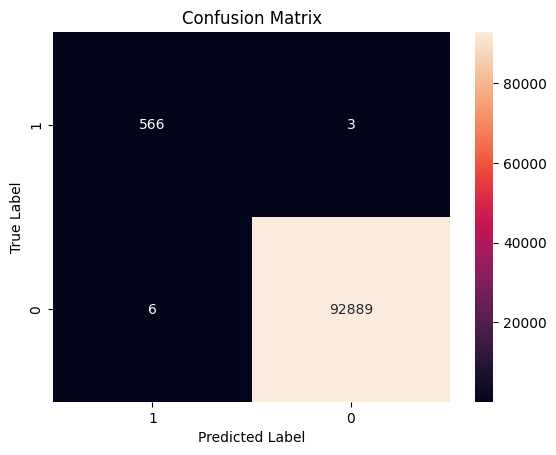

In [28]:
cm = confusion_matrix(y_true, y_preds)
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt='0.0f')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Simple Neural Network: PyTorch

In [29]:
import torch

print(f"Torch version: {torch.__version__}")
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset

Torch version: 2.3.0+cpu


In [30]:
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size=0.15, random_state=42)

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [32]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).type(torch.long)

x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val).type(torch.long)

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test).type(torch.long)

train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)
test_set = TensorDataset(x_test, y_test)

train_dataloader = DataLoader(train_set, batch_size=128)
val_dataloader = DataLoader(val_set, batch_size=128)
test_dataloader = DataLoader(test_set, batch_size=128)

In [33]:
class model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.h1 = Linear(13, 26)
        self.h2 = Linear(26, 26)
        self.h3 = Linear(26, 26)
        self.h4 = Linear(26, 6)
        self.h5 = Linear(6, 2)
    
    def forward(self, x):
        x = self.h1(x).relu()
        x = self.h2(x).relu()
        x = self.h3(x).relu()
        x = self.h4(x).relu()
        x = self.h5(x)

        return x

mlp = model()

In [34]:
optim = Adam(mlp.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()

In [36]:
epochs = 20
tolerance = 1e-3
lambda_ = 1e-5
best_loss = np.inf
patience = 5
early_stop_counter = 0
best_save_path = 'mlp_pytorch_best.pt'
# mlp.cuda()
for e in range(epochs):
    for i, (data, labels) in enumerate(train_dataloader):
        optim.zero_grad()

        # data = data.cuda()
        # labels = labels.cuda()

        preds = mlp.forward(data)
        loss = criterion(preds, labels)

        l2_norm = sum(p.pow(2.0).sum() for p in mlp.parameters())
        loss = loss + lambda_ * l2_norm

        loss.backward()
        optim.step()
        predictions = preds.detach().cpu().numpy().argmax(axis=1)
        y_true = labels.detach().cpu().numpy()
        acc = np.mean(y_true == predictions)
        print(f'\rEpoch {e} / {epochs}: {i}/{len(train_dataloader)} | loss: {loss.item()} acc: {acc}'.ljust(200, ' '), end='')
    
    # Validation

    with torch.no_grad():
        hold = np.array([])
        loss_hold = []
        for i, (data, labels) in enumerate(val_dataloader):
            # data = data.cuda()
            # labels = labels.cuda()

            preds = mlp.forward(data)

            loss = criterion(preds, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in mlp.parameters())
            loss = loss + lambda_ * l2_norm

            predictions = preds.detach().cpu().numpy().argmax(axis=1)
            y_true = labels.detach().cpu().numpy()

            hold = np.concatenate((y_true == predictions, hold))
            loss_hold.append(loss.item())
        
        val_acc = np.mean(hold)
        val_loss = np.mean(loss_hold)
        print(f'\rEpoch {e} / {epochs}: {i}/{len(val_dataloader)} | loss: {loss.item()} acc: {acc} val_loss: {val_loss} val_acc: {val_acc}'.ljust(200, ' '), end='\n')
    
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0

        torch.save(mlp.state_dict(), best_save_path)
    elif abs(best_loss - val_loss) <= tolerance:
        pass
    else:
        early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'\rEpoch {e} / {epochs}: {i}/{len(val_dataloader)} | loss: {loss.item()} acc: {acc} val_loss: {val_loss} val_acc: {val_acc} Early Stopping'.ljust(200, ' '), end='\n')
            mlp.load_state_dict(torch.load(best_save_path))
            break

Epoch 0 / 20: 827/828 | loss: 0.000905855093151331 acc: 1.0 val_loss: 0.004336758054793444 val_acc: 0.9971583935955289                                                                                 
Epoch 1 / 20: 827/828 | loss: 0.0009898539865389466 acc: 1.0 val_loss: 0.002541760129770849 val_acc: 0.9999055944716122                                                                                
Epoch 2 / 20: 827/828 | loss: 0.0009693336323834956 acc: 1.0 val_loss: 0.0025672871841045755 val_acc: 0.9998961539187735                                                                               
Epoch 3 / 20: 827/828 | loss: 0.0007503976230509579 acc: 1.0 val_loss: 0.0024816363507624184 val_acc: 0.9998961539187735                                                                               
Epoch 4 / 20: 827/828 | loss: 0.0011171085061505437 acc: 1.0 val_loss: 0.004344329490311723 val_acc: 0.9996601400978041                                                                                


In [37]:
with torch.no_grad():
    hold = np.array([])
    loss_hold = []
    for i, (data, labels) in enumerate(test_dataloader):
        # data = data.cuda()
        # labels = labels.cuda()

        preds = mlp.forward(data)

        loss = criterion(preds, labels)

        predictions = preds.detach().cpu().numpy().argmax(axis=1)
        y_true = labels.detach().cpu().numpy()

        hold = np.concatenate((y_true == predictions, hold))
        loss_hold.append(loss.item())
        print(f'\rEvaluating {i}/{len(test_dataloader)} | loss: {loss.item()} acc: {np.mean(y_true==predictions)}'.ljust(200, ' '), end='')
    
    test_acc = np.mean(hold)
    test_loss = np.mean(loss_hold)
    print(f'\rEvaluating {i}/{len(test_dataloader)} | loss: {test_loss} acc: {test_acc}'.ljust(200, ' '), end='')

Evaluating 730/731 | loss: 0.0006093252457587395 acc: 0.9999465034665753                                                                                                                               

In [38]:
# preds = mlp.forward(x_test.cuda())
preds = mlp.forward(x_test)

Detach from Cuda and derive the label predictions from the probability scores

In [39]:
y_preds = preds.detach().cpu().numpy().argmax(axis=1)

Original labels become a tensor, so convert back to a numpy array

In [40]:
y_true = y_test.numpy()

Compute precision, racall, f1 scores

In [42]:
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1_measure = f1_score(y_true, y_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1_measure}")

Precision: 0.9982332155477032
Recall: 0.9929701230228472
F1-Measure: 0.9955947136563876


In [43]:
roc_auc_score(y_true, y_preds)

0.9964796790904107

Text(50.722222222222214, 0.5, 'True Label')

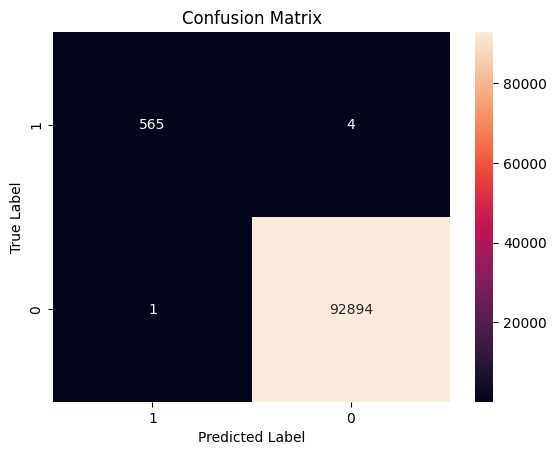

In [44]:
cm = confusion_matrix(y_true, y_preds)
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt='0.0f')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')